In [1]:
!pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss


In [2]:
df = pd.read_csv('/content/Creditcard_data.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


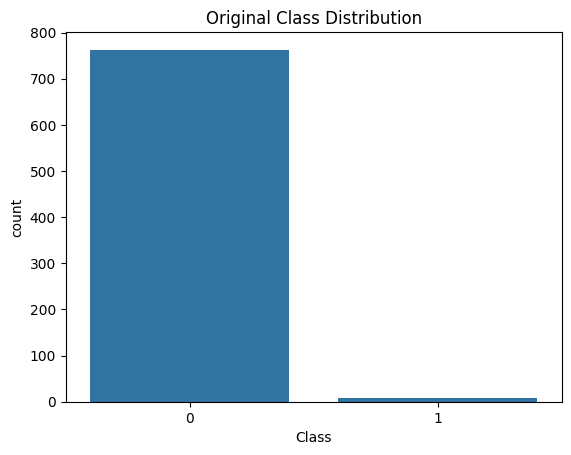

In [3]:
sns.countplot(x='Class', data=df)
plt.title("Original Class Distribution")
plt.show()


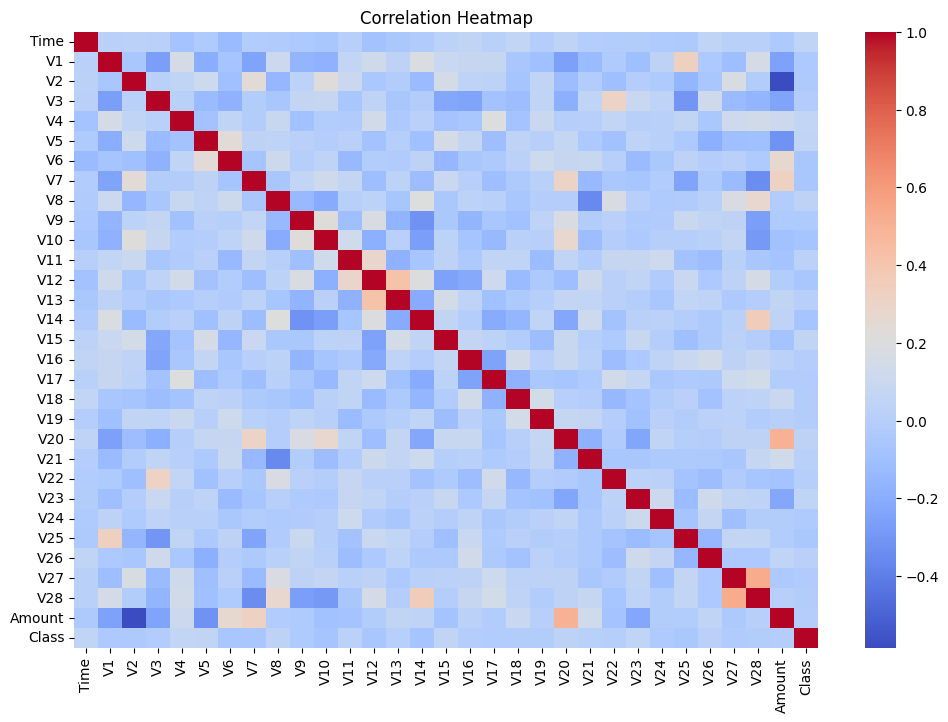

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [5]:
X = df.drop('Class', axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
sampling_methods = {
    "RandomOver": RandomOverSampler(),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(),
    "RandomUnder": RandomUnderSampler(),
    "NearMiss": NearMiss()
}


In [7]:
models = {
    "Logistic": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}


In [8]:
results = pd.DataFrame(columns=["Model","Sampling","Accuracy"])

for samp_name, sampler in sampling_methods.items():
    X_res, y_res = sampler.fit_resample(X_scaled, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=0.2, random_state=42
    )

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)

        results.loc[len(results)] = [model_name, samp_name, acc]


In [9]:
pivot_table = results.pivot(index="Model", columns="Sampling", values="Accuracy")
pivot_table


Sampling,ADASYN,NearMiss,RandomOver,RandomUnder,SMOTE
Model,,,,,
DecisionTree,0.983660,0.75,0.993464,0.0,0.980392
KNN,0.937908,1.00,0.964052,0.5,0.944444
Logistic,0.931373,1.00,0.931373,0.0,0.931373
RandomForest,0.993464,1.00,1.000000,0.0,0.986928
SVM,0.973856,1.00,0.960784,0.0,0.967320


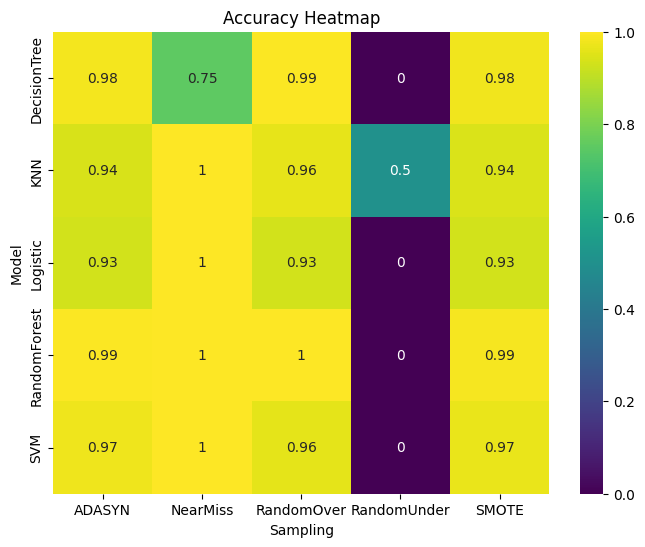

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(pivot_table, annot=True, cmap="viridis")
plt.title("Accuracy Heatmap")
plt.show()


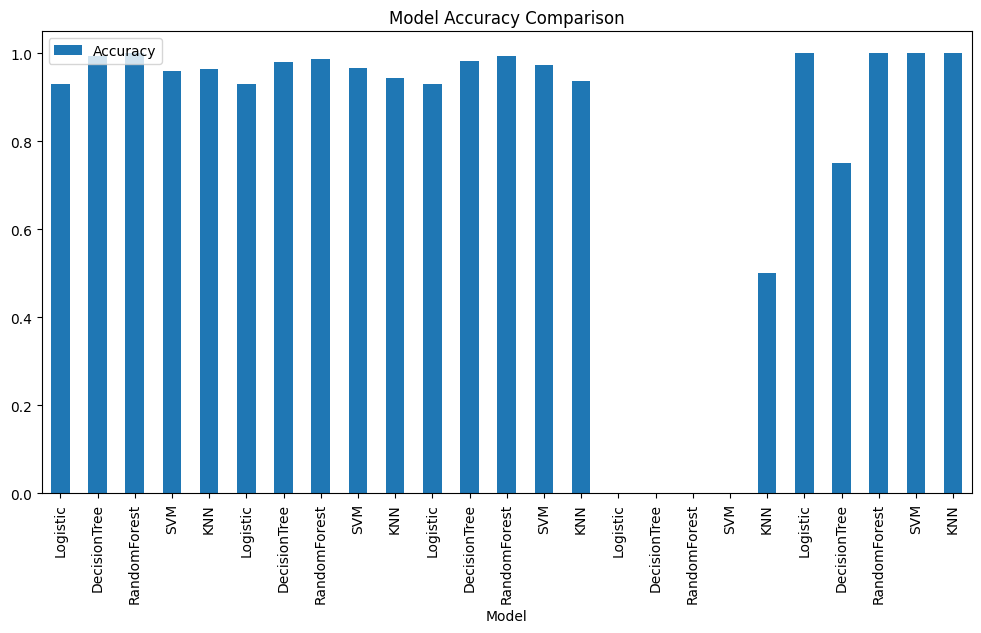

In [11]:
results.plot(kind='bar', x='Model', y='Accuracy', figsize=(12,6))
plt.title("Model Accuracy Comparison")
plt.show()


In [12]:
best_sampling = results.loc[results.groupby('Model')['Accuracy'].idxmax()]
best_sampling


,Model,Sampling,Accuracy
1,DecisionTree,RandomOver,0.993464
24,KNN,NearMiss,1.000000
20,Logistic,NearMiss,1.000000
2,RandomForest,RandomOver,1.000000
23,SVM,NearMiss,1.000000


In [13]:
best_model_name = best_sampling.iloc[0]['Model']
best_sampling_name = best_sampling.iloc[0]['Sampling']

best_model = models[best_model_name]
best_sampler = sampling_methods[best_sampling_name]

X_res, y_res = best_sampler.fit_resample(X_scaled, y)
best_model.fit(X_res, y_res)

def predict_sample(sample):
    sample_scaled = scaler.transform([sample])
    return best_model.predict(sample_scaled)


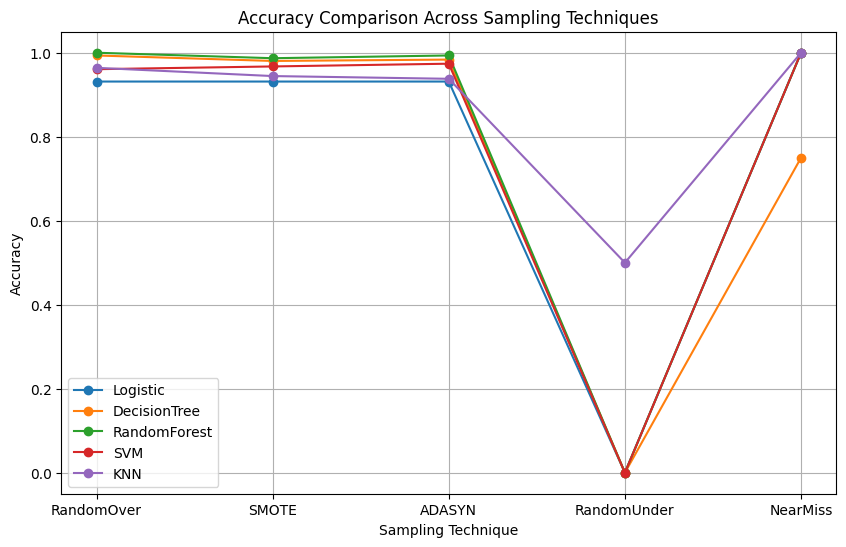

In [14]:
plt.figure(figsize=(10,6))

for model in results['Model'].unique():
    subset = results[results['Model'] == model]
    plt.plot(subset['Sampling'], subset['Accuracy'], marker='o', label=model)

plt.title("Accuracy Comparison Across Sampling Techniques")
plt.xlabel("Sampling Technique")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


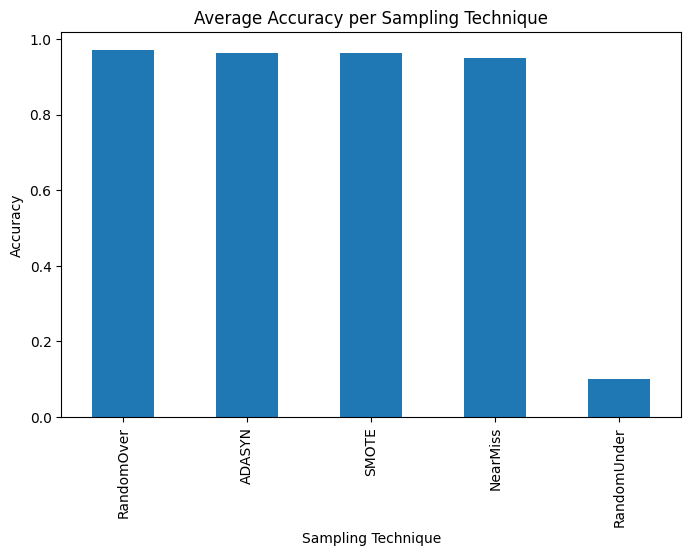

In [15]:
avg_sampling = results.groupby('Sampling')['Accuracy'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
avg_sampling.plot(kind='bar')
plt.title("Average Accuracy per Sampling Technique")
plt.ylabel("Accuracy")
plt.xlabel("Sampling Technique")
plt.show()


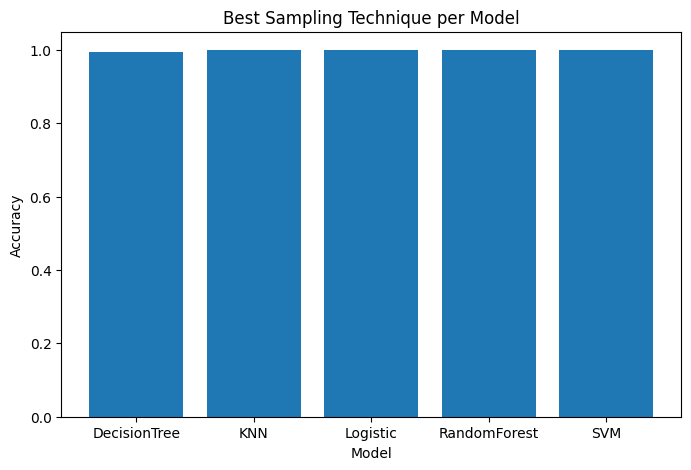

           Model    Sampling  Accuracy
1   DecisionTree  RandomOver  0.993464
24           KNN    NearMiss  1.000000
20      Logistic    NearMiss  1.000000
2   RandomForest  RandomOver  1.000000
23           SVM    NearMiss  1.000000


In [16]:
best_sampling = results.loc[results.groupby('Model')['Accuracy'].idxmax()]

plt.figure(figsize=(8,5))
plt.bar(best_sampling['Model'], best_sampling['Accuracy'])
plt.title("Best Sampling Technique per Model")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.show()

print(best_sampling)


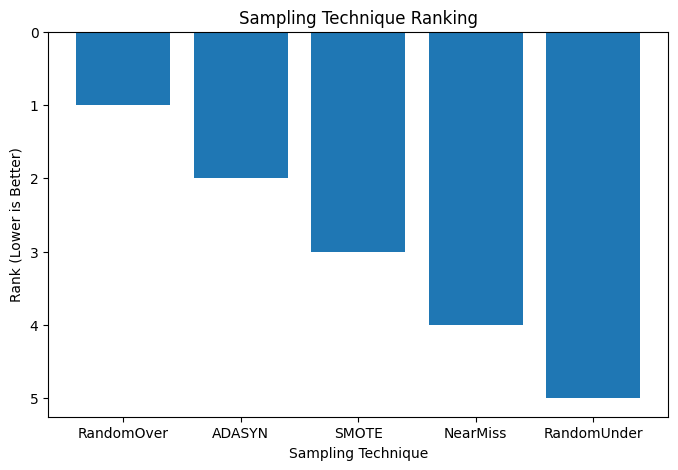

In [17]:
ranking = avg_sampling.rank(ascending=False)

plt.figure(figsize=(8,5))
plt.bar(ranking.index, ranking.values)
plt.title("Sampling Technique Ranking")
plt.ylabel("Rank (Lower is Better)")
plt.xlabel("Sampling Technique")
plt.gca().invert_yaxis()
plt.show()


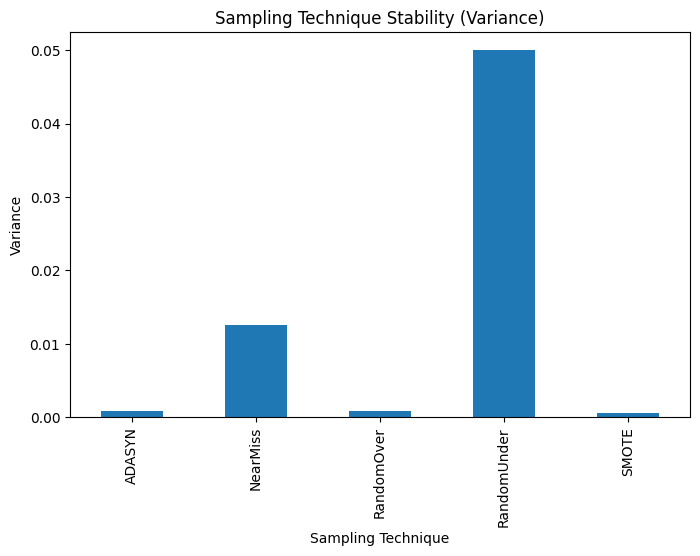

In [18]:
variance_sampling = results.groupby('Sampling')['Accuracy'].var()

plt.figure(figsize=(8,5))
variance_sampling.plot(kind='bar')
plt.title("Sampling Technique Stability (Variance)")
plt.ylabel("Variance")
plt.xlabel("Sampling Technique")
plt.show()


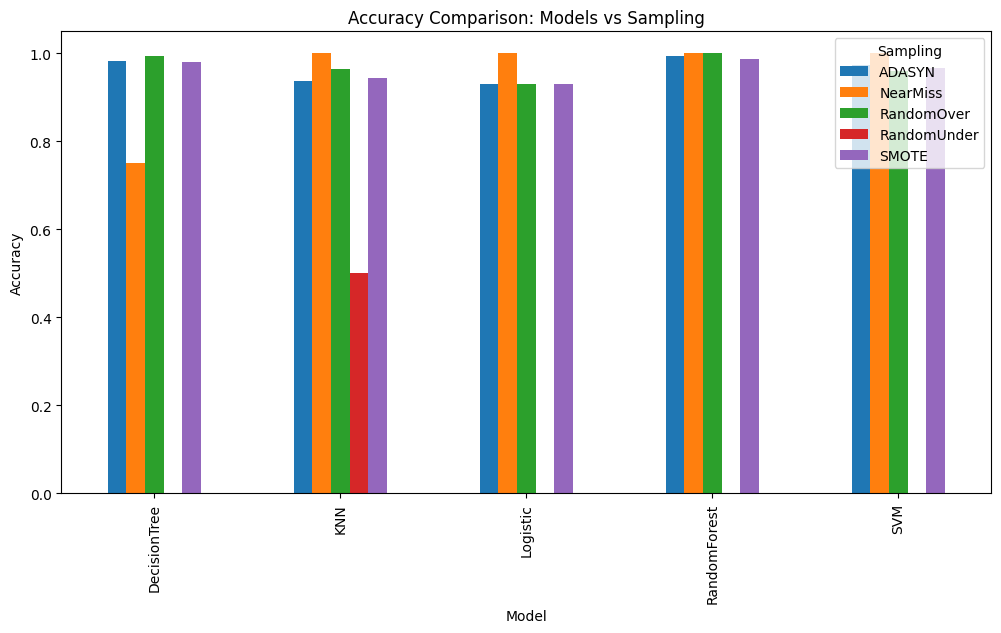

In [19]:
pivot = results.pivot(index='Model', columns='Sampling', values='Accuracy')

pivot.plot(kind='bar', figsize=(12,6))
plt.title("Accuracy Comparison: Models vs Sampling")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend(title="Sampling")
plt.show()


In [20]:
!pip install xgboost

from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier


In [21]:
models = {
    "Logistic": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "NaiveBayes": GaussianNB(),
    "GradientBoost": GradientBoostingClassifier()
}


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

results = []

for samp_name, sampler in sampling_methods.items():
    X_res, y_res = sampler.fit_resample(X_scaled, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=0.2, random_state=42
    )

    for model_name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()

        preds = model.predict(X_test)

        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)[:,1]
            roc = roc_auc_score(y_test, probs)
        else:
            roc = 0

        results.append([
            model_name,
            samp_name,
            accuracy_score(y_test, preds),
            precision_score(y_test, preds),
            recall_score(y_test, preds),
            f1_score(y_test, preds),
            roc,
            end-start
        ])

results_df = pd.DataFrame(results, columns=[
    "Model","Sampling","Accuracy","Precision","Recall","F1","ROC_AUC","Time"
])

results_df.head()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:30:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:30:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:30:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and 

,Model,Sampling,Accuracy,Precision,Recall,F1,ROC_AUC,Time
0,Logistic,RandomOver,0.931373,0.885870,1.0,0.939481,0.938350,0.016041
1,DecisionTree,RandomOver,0.990196,0.981928,1.0,0.990881,0.989510,0.015100
2,RandomForest,RandomOver,1.000000,1.000000,1.0,1.000000,1.000000,0.398256
3,SVM,RandomOver,0.960784,0.931429,1.0,0.964497,1.000000,0.421544
4,KNN,RandomOver,0.964052,0.936782,1.0,0.967359,0.986014,0.000688


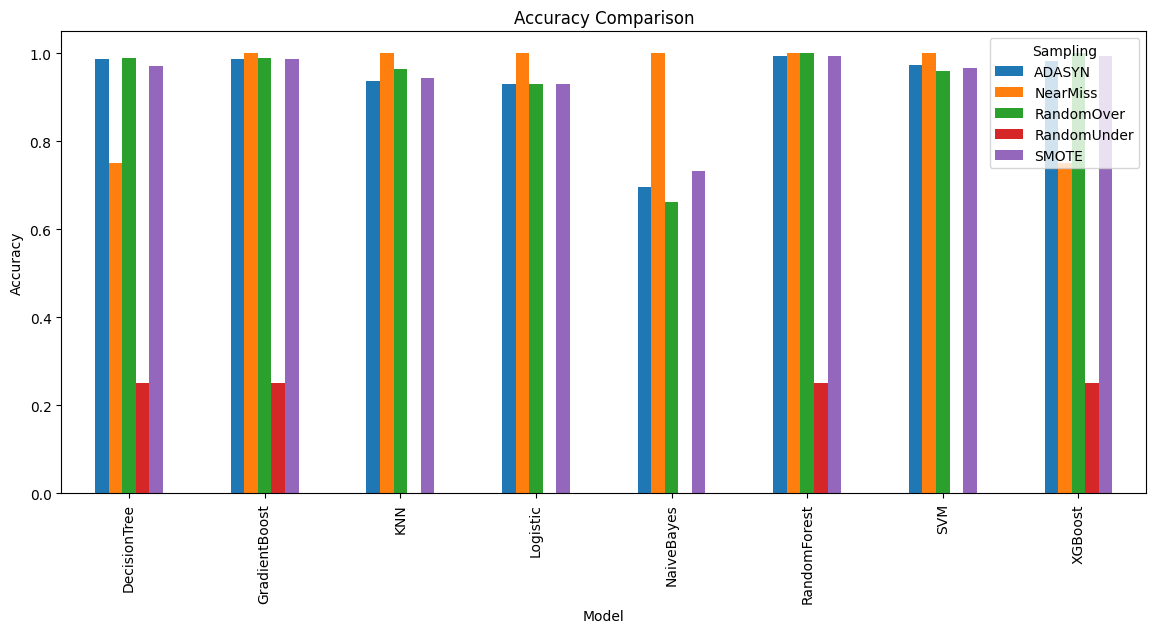

In [23]:
pivot_acc = results_df.pivot(index="Model", columns="Sampling", values="Accuracy")

pivot_acc.plot(kind='bar', figsize=(14,6))
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


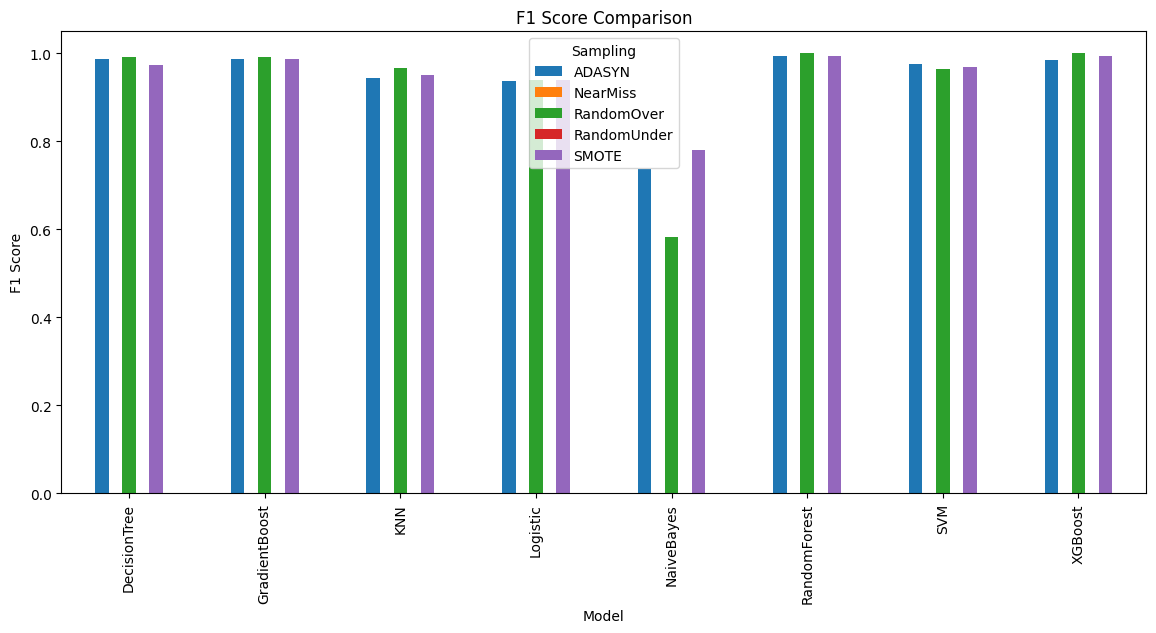

In [24]:
pivot_f1 = results_df.pivot(index="Model", columns="Sampling", values="F1")

pivot_f1.plot(kind='bar', figsize=(14,6))
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.show()


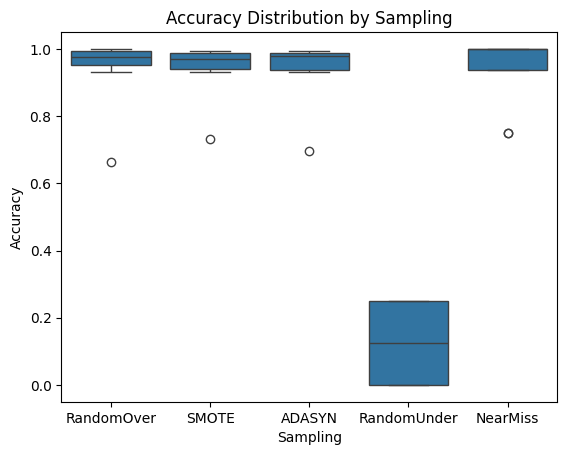

In [25]:
sns.boxplot(x="Sampling", y="Accuracy", data=results_df)
plt.title("Accuracy Distribution by Sampling")
plt.show()


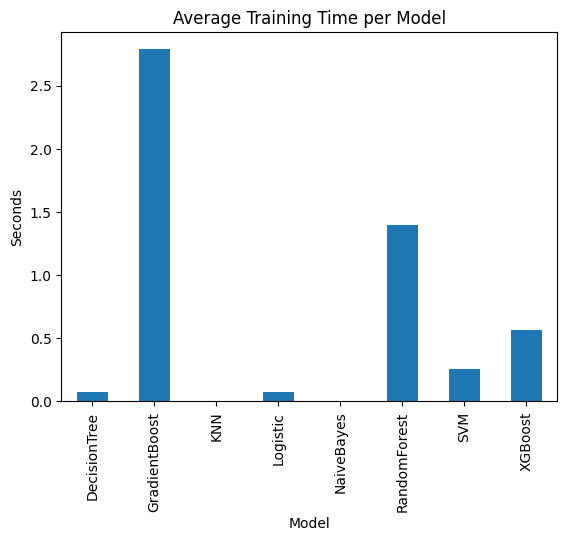

In [26]:
time_avg = results_df.groupby("Model")["Time"].mean()

time_avg.plot(kind='bar')
plt.title("Average Training Time per Model")
plt.ylabel("Seconds")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:

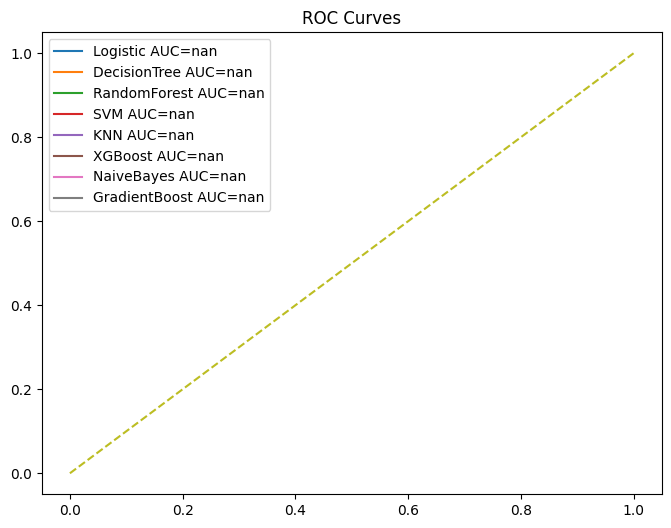

In [27]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, model in models.items():
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} AUC={auc(fpr,tpr):.2f}")

plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curves")
plt.show()


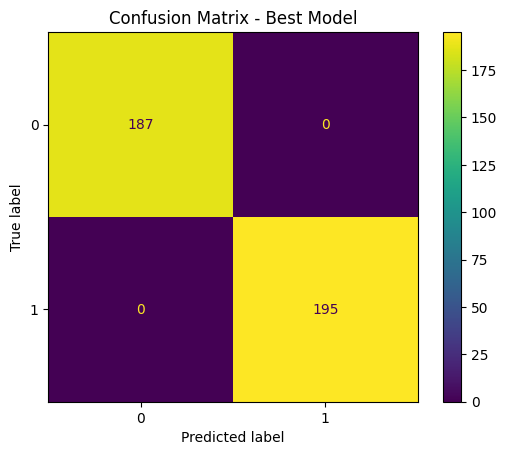

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best = results_df.loc[results_df["Accuracy"].idxmax()]
best_model = models[best["Model"]]
best_sampler = sampling_methods[best["Sampling"]]

X_res, y_res = best_sampler.fit_resample(X_scaled, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix - Best Model")
plt.show()

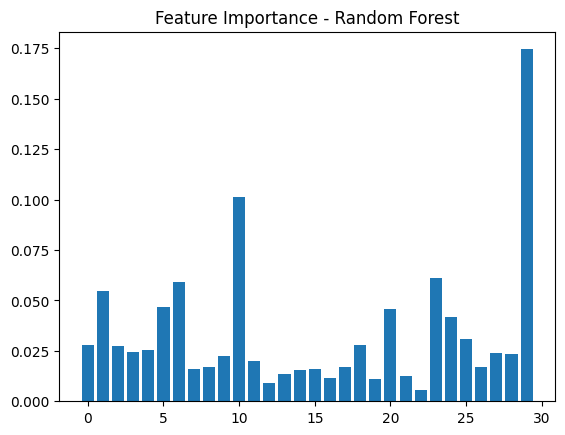

In [30]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)
plt.title("Feature Importance - Random Forest")
plt.show()


In [31]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(RandomForestClassifier(), X_scaled, y, cv=5)
print("Cross Validation Accuracy:", cv_scores.mean())


Cross Validation Accuracy: 0.9896439044826142


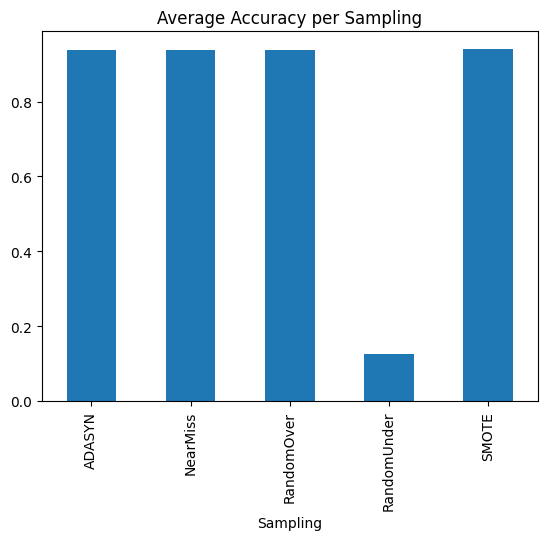

In [32]:
avg_sampling = results_df.groupby("Sampling")["Accuracy"].mean()
avg_sampling.plot(kind='bar')
plt.title("Average Accuracy per Sampling")
plt.show()


In [33]:

import os
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

# 1. CREATE FOLDER
folder_path = "plots"
os.makedirs(folder_path, exist_ok=True)

# 2. SAVE FUNCTION
def save_plot(name):
    plt.savefig(f"{folder_path}/{name}.png", dpi=300, bbox_inches='tight')
    plt.close()

# 3. ACCURACY BAR
pivot_acc.plot(kind='bar', figsize=(14,6))
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
save_plot("accuracy_bar")

# 4. F1 SCORE BAR
pivot_f1.plot(kind='bar', figsize=(14,6))
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
save_plot("f1_bar")

# 5. BOX PLOT
plt.figure(figsize=(8,6))
sns.boxplot(x="Sampling", y="Accuracy", data=results_df)
plt.title("Sampling Stability")
save_plot("sampling_boxplot")

# 6. ROC CURVE
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
save_plot("roc_curve")

# 7. CONFUSION MATRIX
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
save_plot("confusion_matrix")

# 8. FEATURE IMPORTANCE
plt.figure(figsize=(10,5))
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)
plt.title("Feature Importance")
save_plot("feature_importance")

# 9. AVERAGE SAMPLING ACCURACY
avg_sampling.plot(kind='bar', figsize=(8,5))
plt.title("Average Sampling Accuracy")
save_plot("avg_sampling_accuracy")

# 10. TRAINING TIME
time_avg.plot(kind='bar', figsize=(8,5))
plt.title("Training Time per Model")
save_plot("training_time")

# 11. ZIP ALL IMAGES FOR DOWNLOAD
zip_name = "plots.zip"
with ZipFile(zip_name, 'w') as zipf:
    for file in os.listdir(folder_path):
        zipf.write(os.path.join(folder_path, file))

print("All plots saved and zipped as plots.zip")


All plots saved and zipped as plots.zip


In [1]:

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# 1. DEFINE SAMPLERS
sampling_methods = {
    "RandomOverSampling": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "RandomUnderSampling": RandomUnderSampler(random_state=42),
    "NearMiss": NearMiss()
}

print("Sampling Techniques Used:")
for name in sampling_methods.keys():
    print("-", name)

# 2. APPLY EACH SAMPLING TECHNIQUE
sampled_datasets = {}

for name, sampler in sampling_methods.items():
    X_resampled, y_resampled = sampler.fit_resample(X_scaled, y)
    sampled_datasets[name] = (X_resampled, y_resampled)
    
    print(f"\n{name}")
    print("Resampled Shape:", X_resampled.shape)
    print("Class Distribution:", 
          dict(zip(*np.unique(y_resampled, return_counts=True))))


Sampling Techniques Used:
- RandomOverSampling
- SMOTE
- ADASYN
- RandomUnderSampling
- NearMiss


NameError: name 'X_scaled' is not defined

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. ORIGINAL CLASS DISTRIBUTION
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Original Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 2. AFTER EACH SAMPLING TECHNIQUE
for name, (X_resampled, y_resampled) in sampled_datasets.items():
    plt.figure(figsize=(5,4))
    sns.countplot(x=y_resampled)
    plt.title(f"Class Distribution After {name}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# 3. COMBINED BAR COMPARISON (OPTIONAL)
labels = list(sampling_methods.keys())
minority_counts = []
majority_counts = []

for name, (X_resampled, y_resampled) in sampled_datasets.items():
    unique, counts = np.unique(y_resampled, return_counts=True)
    count_dict = dict(zip(unique, counts))
    minority_counts.append(count_dict.get(1, 0))
    majority_counts.append(count_dict.get(0, 0))

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, majority_counts, width, label='Majority')
plt.bar(x + width/2, minority_counts, width, label='Minority')

plt.xticks(x, labels, rotation=30)
plt.ylabel("Sample Count")
plt.title("Class Balance Comparison Across Sampling Techniques")
plt.legend()
plt.show()
